# Metrics for the Oscillatory model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm, uniform
from scipy.integrate import dblquad
import random
import emcee

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

2022-11-16 15:35:04.668038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 15:35:04.668053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


# Oscillation model        
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21


def batch_simulator_augment01(prior_samples, n_obs):   
    """
    Simulate multiple oscillation model datasets with missing values and augmentation by zeros/ones
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations  
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        sim_data[m, :, 0] = np.sin(a*2*np.pi*time_points) + b + np.random.normal(0, sigma, size=n_obs)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-5.0, 0.0])
        
    return sim_data   


def batch_simulator_timepoints(prior_samples, n_obs):   
    """
    Simulate multiple oscillation model datasets with missing values and time labels (present time points)
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    n_missing = np.random.randint(0, missing_max+1)
    n_present = n_obs - n_missing
    sim_data = np.empty((n_sim, n_present, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_present observations
    
    for m in range(n_sim):
        a = prior_samples[m, 0]   # frequency
        b = prior_samples[m, 1]   # shift
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing)
        present_indices = np.setdiff1d(range(n_obs), missing_indices)
        present_timepoints = time_points[present_indices]
        sim_data[m, :, 0] = np.sin(a*2*np.pi*present_timepoints) + b + np.random.normal(0, sigma, size=n_present)
        sim_data[m, :, 1] = present_timepoints   # time labels
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## MCMC samples

In [5]:
n_params = 100   # you should change it to 500
true_params = prior(n_params) 
x_augment01 = batch_simulator_augment01(true_params, n_obs).astype(np.float32)

In [6]:
%%time

# TODO The likelihood seems messed up, results are wrong compared to true parameters

# "True" means via MCMC sampling
mcmc_means = np.empty((n_params, 2))

from multiprocessing import Pool

from tqdm import tqdm

def do_sth(i):
    present_timepoints = time_points[x_augment01[i,:,1]==1]
    present_data = x_augment01[i, x_augment01[i,:,1]==1, 0]
    
    def log_prior(x,y):
        return uniform.logpdf(x, 0.1, 0.9) + norm.logpdf(y, 0, 0.25)

    def log_likelihood(a, b):   
        # Calculates log-likelihood p(x_{1:N} | theta) by ignoring the missing data
        sim_state = np.sin(a*2*np.pi*present_timepoints) + b
        residual = (present_data - sim_state)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return - nllh

    def log_posterior(x,y):   
        # Evaluates the unnormalized log-posterior probability p(theta | x_{1:N}) according to Bayes' formula
        return log_likelihood(x,y) + log_prior(x,y)

    def log_posterior_v(x: np.ndarray):
        """Log-posterior with a single vector-valued argument."""
        x, y = x
        return log_posterior(x, y)

    def sample(n_sample=10000, n_walker=10):
        """Perform sampling using emcee."""
        n_dim = 2
        p0 = np.random.randn(n_walker, n_dim)
        #with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(n_walker, n_dim, log_posterior_v)
        sampler.run_mcmc(p0, n_sample)    
        samples = sampler.get_chain(flat=True)
        return samples

    # Sample
    samples = sample(n_sample=10000)
    
    # Posterior mean
    return (i, samples)

with Pool() as pool:
    results = list(tqdm(pool.imap_unordered(do_sth, range(n_params)), total=n_params))

  0%|                                                                                                             | 0/100 [00:00<?, ?it/s]/home/yannik/miniconda3/envs/bayesflow/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/yannik/miniconda3/envs/bayesflow/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/yannik/miniconda3/envs/bayesflow/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/yannik/miniconda3/envs/bayesflow/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/yannik/miniconda3/envs/bayesflow/lib/python3.10/site-packages/emcee/move

CPU times: user 1.18 s, sys: 233 ms, total: 1.42 s
Wall time: 11min 23s


In [7]:
results = sorted(results, key=lambda x: x[0])
mcmc_samples = np.array([r for _, r in results])
print(mcmc_samples.shape)
mcmc_means = np.mean(mcmc_samples, axis=1)
print(mcmc_means.shape)
#mcmc_means = np.array([r for _, r in results])

(100, 100000, 2)
(100, 2)


In [8]:
mcmc_means[:10, :]

array([[-0.02171816, -0.25693805],
       [-0.18179625,  0.11345989],
       [-0.17994966,  0.02960563],
       [ 0.33596793,  0.13512631],
       [-0.10342857,  0.10401945],
       [-0.19429014,  0.19579613],
       [-0.10340899, -0.07704168],
       [ 0.28696005, -0.2940113 ],
       [ 0.09209097,  0.13815136],
       [-0.06127207,  0.21696702]])

## Save results

In [9]:
np.save("true_params.npy", true_params)
np.save("mcmc_means.npy", mcmc_means)
np.save("mcmc_samples.npy", mcmc_samples)
np.save("x_augment01.npy", x_augment01)

## Load results

In [10]:
true_params = np.load("true_params.npy")
mcmc_means = np.load("mcmc_means.npy")
mcmc_samples = np.load("mcmc_samples.npy")
x_augment01 = np.load("x_augment01.npy")

## Computational faithfulness

In [11]:
# Augment01
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer_augment01 = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(
    network=amortizer_augment01,
    checkpoint_path='./Oscillation41__augment01__5ACB__64_64_64__LSTM_128__ckpts', 
    skip_checks=True,
)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer_augment01.sample(x_augment01, n_samples=1000)
v_augment01 = bootstrap_metrics(np.swapaxes(param_samples_augment01, 0, 1), true_params)
a1 = display_metrics(v_augment01)

2022-11-16 16:05:42.843360: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 16:05:42.843387: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 16:05:42.843406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yoga): /proc/driver/nvidia/version does not exist
2022-11-16 16:05:42.843638: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41__augment01__5ACB__64_64_64__LSTM_128__ckpts/ckpt-303
NRMSE(k_1): 0.000 ± 0.000
NRMSE(k_2): 0.009 ± 0.001
R²(k_1): 1.000 ± 0.000
R²(k_2): 0.999 ± 0.000


In [12]:
# Timepoints
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer_timepoints = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(
    network=amortizer_timepoints,
    checkpoint_path='./Oscillation41__timepoints__5ACB__64_64_64__LSTM_128__ckpts', 
    skip_checks=True,
)

# BayesFlow samples from the learned posterior
param_samples_timepoints = np.empty((n_params, 1000, 2), dtype=np.float32)
for m in range(n_params):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_timepoints = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_timepoints[0, :, 0] = x_augment01[m, present_indices, 0]
    x_timepoints[0, :, 1] = time_points[present_indices]
    param_samples_timepoints[m] = amortizer_timepoints.sample(x_timepoints, n_samples=1000)
v_timepoints = bootstrap_metrics(np.swapaxes(param_samples_timepoints, 0, 1), true_params)
a3 = display_metrics(v_timepoints)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41__timepoints__5ACB__64_64_64__LSTM_128__ckpts/ckpt-300
NRMSE(k_1): 0.009 ± 0.003
NRMSE(k_2): 0.019 ± 0.002
R²(k_1): 0.999 ± 0.001
R²(k_2): 0.994 ± 0.001


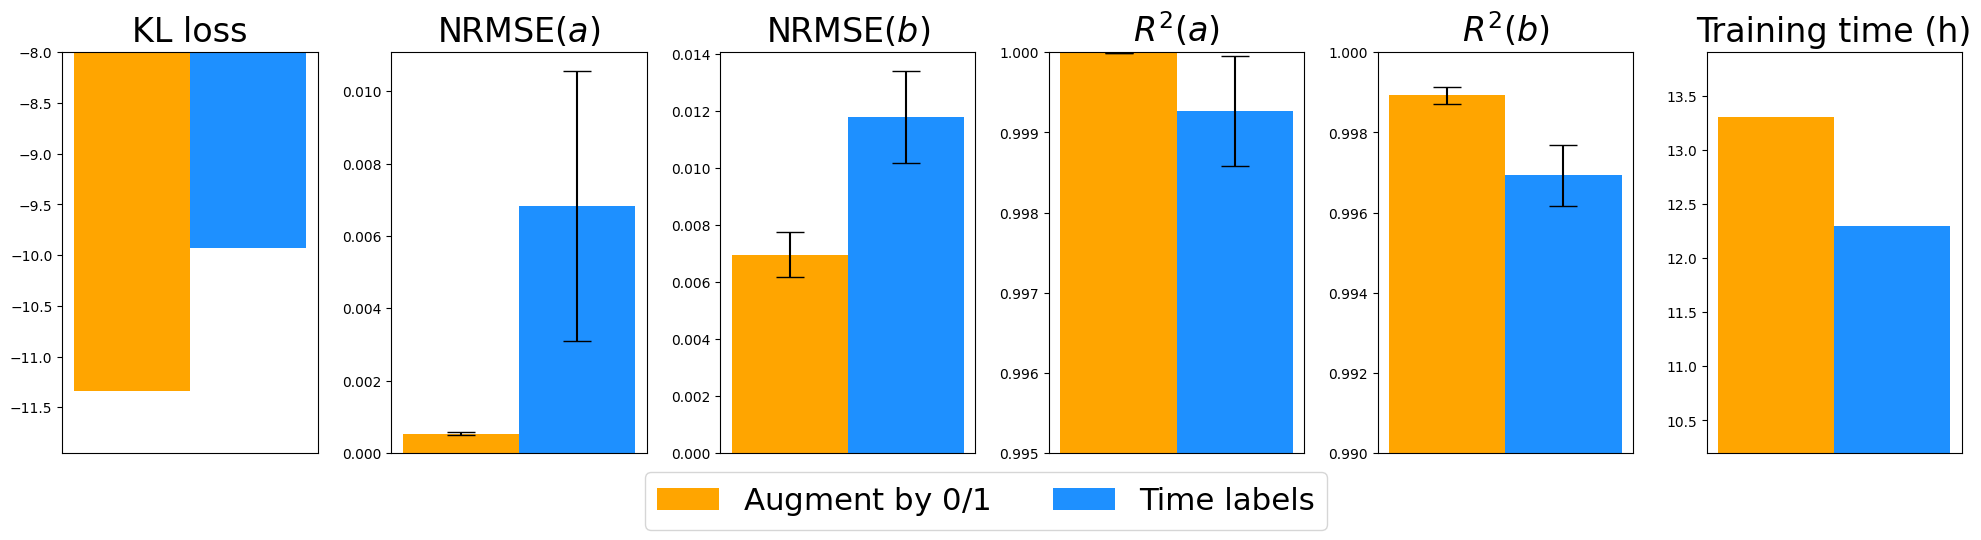

In [11]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
plt.rcParams['font.size'] = 16

bar_chart(ax, np.array([-11.338, -9.929]), 0, 'KL loss', y_lim=np.array([-11.95, -8]))
bar_chart(ax, np.array([a1[0,0], a3[0,0]]), 1, 'NRMSE$(a)$', 
          se=np.array([a1[1,0], a3[1,0]]), y_lim=None)
bar_chart(ax, np.array([a1[0,1], a3[0,1]]), 2, 'NRMSE$(b)$', 
          se=np.array([a1[1,1], a3[1,1]]), y_lim=None)
bar_chart(ax, np.array([a1[0,2], a3[0,2]]), 3, '$R^2(a)$', 
          se=np.array([a1[1,2], a3[1,2]]), 
          y_lim=np.array([0.995, 1.]), y_ticks=None)
bar_chart(ax, np.array([a1[0,3], a3[0,3]]), 4, '$R^2(b)$', 
          se=np.array([a1[1,3], a3[1,3]]), 
          y_lim=np.array([0.99, 1.]), y_ticks=None)
bar_chart(ax, np.array([13+18/60, 12+18/60]), 5, 'Training time (h)', 
          y_lim=np.array([10.2, 13.9]), y_ticks=np.array([10.5, 11, 11.5, 12, 12.5, 13, 13.5]))

for axes in ax: 
    handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.12), ncol=2, fontsize=22.25)
plt.tight_layout()
plt.show()
fig.savefig("figures/{}_bar_chart.png".format('Oscillation'), dpi=600, bbox_inches='tight')

SBC plot: similarly good => no systematic bias

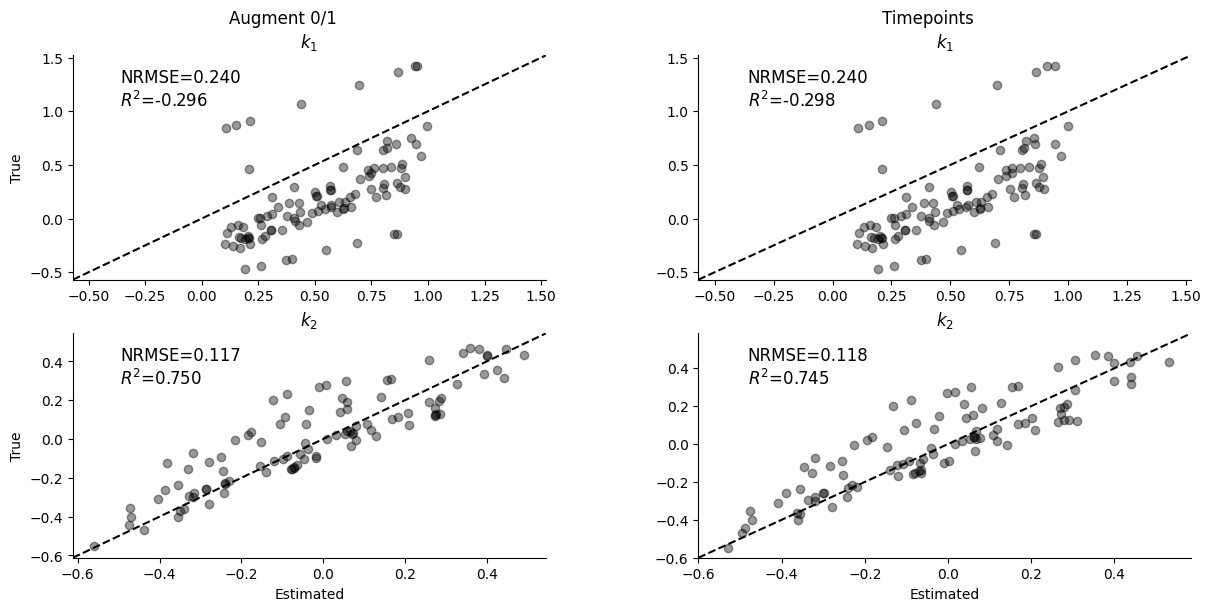

In [14]:
def true_vs_estimated(axarr, theta_true, theta_est, param_names):
    """ Plots a scatter plot with abline of the estimated posterior means vs true values. """
        
    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(param_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(theta_est[:, j], theta_true[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSE
        rmse = np.sqrt(np.mean( (theta_est[:, j] - theta_true[:, j])**2 ))
        nrmse = rmse / (theta_true[:, j].max() - theta_true[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=12)
        
        # Compute R2
        r2 = r2_score(theta_true[:, j], theta_est[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes, 
                     size=12)
        
        axarr[j].set_ylabel('True')
        if j == len(param_names) - 1:
            # Label plot
            axarr[j].set_xlabel('Estimated')
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)

x = [1, 2, 3]
y = [4, 5, 6]

fig = plt.figure(figsize=(12, 6), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=2, wspace=0.15)
all_axes = [subfig.subplots(nrows=2, ncols=1, gridspec_kw={'wspace': 0}) for subfig in subfigs.ravel()]

for ix, (samples, label) in enumerate([
    (param_samples_augment01, "Augment 0/1"),
    #(param_samples_insert, "Insert -1"),
    (param_samples_timepoints, "Timepoints")
]):
    bayesflow_means = np.mean(samples, axis=1)
    axes = all_axes[ix].flat
    true_vs_estimated(axes, true_params, bayesflow_means, ["$k_1$", "$k_2$"])
    subfigs[ix].suptitle(label)
    if ix > 0:
        for ax in axes:
            ax.set_ylabel(None)

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/CR3_true_vs_estimated.{fmt}", dpi=300, bbox_inches='tight')